In [1]:
import xarray as xr
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.ticker as mticker
%matplotlib inline
from pprint import pprint
import os
from datetime import datetime
import calendar
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
import cartopy
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates


/fs/homeu1/eccc/crd/ccrn_shr/sah002/.conda/envs/py3_analysis_sjh/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
#methods

def checkFileList(year, month, dir1, dir2):
    file_list1 = []
    file_list2 = []
    for file_dir, file_list in zip([dir1,dir2],[file_list1,file_list2]):
        for root, dirs, files in os.walk(file_dir):
            for file in files:
                if file.startswith(str(year)+str(month).zfill(2)) and file.endswith(".nc"):
                    file_list.append(file)
    return set(file_list1).symmetric_difference(file_list2)
    

def getDailyMean(year, month, day, base_dir, run):
    file_list=[]
    for root, dirs, files in os.walk(base_dir+run+'/'):
        for file in files:
            if file.startswith(str(year) + str(month).zfill(2) + str(day).zfill(2)) and file.endswith(".nc") and not (file.endswith('24.nc')):
                file_list.append(xr.open_dataset(os.path.join(root, file)))
  
    daily_data = xr.concat(file_list, dim='time')
    daily_mean = daily_data.mean(dim='time')
    
    return daily_mean



def getMonthlyMean(year, month, start_day, end_day, base_dir, run, save=False):
    #find all .nc files from month
    day_dict = {}
    for day in np.arange(start_day, end_day+1):
        day_dict[day] = []
    file_list = []
    for root, dirs, files in os.walk(base_dir+run+'/'):
        for file in files:
            if file.startswith(str(year) + str(month).zfill(2)) and file.endswith(".nc"):
                file_day = int(file[6:8])
                if file_day in day_dict.keys():
                    day_dict[int(file[6:8])].append(os.path.join(root, file))

    #make daily means
    for day, file_list in day_dict.items():
        try:
            start_file_set = False
            for file in file_list:
                if (start_file_set == False) and (file.endswith('24.nc')==False):
                    start_file = file
                    data = xr.open_dataset(start_file)
                    start_file_set = True
                if start_file_set == True:
                    try:
                        data1 = xr.open_dataset(file)
                        data = xr.concat((data1,data), dim='time')
                    except:
                        print('skipping ', file)
                        continue
            print('averaging day ' + str(day))
            day_dict[day] = data.mean(dim='time')   
        except Exception as e: 
            print('*** skipping day ', day)
            print(e)
            continue

    #make monthly mean
    daily_means = []
    for day, mean in day_dict.items():
        if len(mean) != 0:
            daily_means.append(mean)
    print(len(daily_means))
    monthly_data = xr.concat(daily_means, dim='time')
    monthly_mean = monthly_data.mean(dim='time')
    if save:
        save_locn = os.path.join(base_dir,run,('mean_'+str(year)+str(month).zfill(2)+'_'+str(start_day).zfill(2)+'-'+str(end_day).zfill(2)+'.nc'))
        monthly_mean.to_netcdf(save_locn)
    return monthly_mean

       
def getAnnualMean(year, base_dir, run ):
    month_ds_list=[]
    for month, end_day in zip([1,2,3,4,5,6,7,8,9,10,11,12],[31,28,31,30,31,30,31,31,30,31,30,31]):
        try:
            month_file = os.path.join(base_dir,run,('mean_'+str(year)+str(month).zfill(2)+'_01-'+str(end_day).zfill(2)+'.nc'))
            month_ds = xr.open_dataset(month_file)
            month_ds_list.append(month_ds)
            print(month_file)
        except Exception as e:
            print('***** skipping ' + str(month))
            print(e)
    annual_data = xr.concat(month_ds_list, dim='time')
    annual_mean = annual_data.mean(dim='time')
    return annual_mean
    
    
def mapPlot(var1,var2,level,data1,data2, time=None, savefig=False, closefig=False, save_path=None):
    fig = plt.figure(figsize=(20,10))
    
    if level==None: 
        data_1 = data1[var1]
        data_2 = data2[var2]
    else:
        if 'time' in data1.dims:
            data_1 = data1[var1][0][level]
            data_2 = data2[var2][0][level]
        else:
            data_1 = data1[var1][level]
            data_2 = data2[var2][level]

    
    #vmin = -10*np.std(data_1)
    #vmax = 10*np.std(data_1)  
    
    ax2 = plt.subplot(2,2,1,projection=ccrs.Robinson())
    im2 = ax2.pcolormesh(data_1.lon, data_1.lat, data_1, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
    vmin, vmax = im2.get_clim() # top row plot limits #
    im2.set_clim(vmin, vmax)
    cb1 = fig.colorbar(im2, ax=ax2)
    cb1.ax.set_ylabel(var1)
    ax2.set_title('Baseline (Surface)')
    #ax2.set_title(var1)

    ax4 = plt.subplot(2,2,2,projection=ccrs.Robinson())
    im4 = ax4.pcolormesh(data_2.lon, data_2.lat, data_2, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
    im4.set_clim(vmin, vmax)
    cb2 = fig.colorbar(im4, ax=ax4)
    cb2.ax.set_ylabel(var2)
    ax4.set_title('Test (Surface)')
    #ax4.set_title(var2)

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['grey','r', 'b','g','c','m','yellow','lime','plum','peru','pink','dodgerblue','tan'])
    bounds=[0,0.25,0.5,0.75,1.25,1.5,1.75,2.25,2.5,3.5,4.5,5.5,6.5,10,100]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    pdiff = data_2-data_1
    ax6 = plt.subplot(2,2,3,projection=ccrs.Robinson())
    im6 = ax6.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=plt.cm.bwr, transform=ccrs.PlateCarree())
    #im6 = ax6.pcolormesh(data1.lon, data1.lat, pdiff, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    vmind, vmaxd = im6.get_clim()
    im6.set_clim(-vmaxd, vmaxd)
    cb3 = fig.colorbar(im6, ax=ax6)
    #cbar_num_format = "%0.2f"
    #cb3 = fig.colorbar(im6, ax=ax6, cmap=cmap,norm=norm, boundaries=bounds, ticks=bounds,format=cbar_num_format)
    cb3.ax.set_ylabel(var1)
    ax6.set_title('Absolute Difference (Test-Baseline)')
    
    pdiff = ((data_2/data_1)-1)*100 
    ax8 = plt.subplot(2,2,4,projection=ccrs.Robinson())
    im8 = ax8.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=plt.cm.bwr, transform=ccrs.PlateCarree())
    #vmin8, vmax8 = im8.get_clim()
    im8.set_clim(-100, 100)
    cb8 = fig.colorbar(im8, ax=ax8)
    cb8.ax.set_ylabel('%')
    ax8.set_title('% Difference (((Test/Baseline)-1)*100)')

    for ax in [ax2,ax4,ax6,ax8]:
        ax.coastlines()

    if savefig == True:
        plt.savefig(save_path,bbox_inches='tight')
    if closefig == True:
        plt.close()
        
def zonalMean(var,data1,data2, max_ht = 0., time=None, savefig=False, closefig=False, save_path=None):    
    fig = plt.figure(figsize=(20,10))
    
    data_1 = data1[var].mean(dim=['lon'])
    data_2 = data2[var].mean(dim=['lon'])
    
    try:
        data_1 = data_1.mean(dim=['time'])
        data_2 = data_2.mean(dim=['time'])
    except:
        print("no time dim")
        
    ax1 = plt.subplot(2,2,1)
    cbt = ax1.contourf(data_1.lat, data_1.level, data_1)
    cntr = ax1.contour(data_1.lat, data_1.level, data_1, 10, colors='w', linewidths=1, alpha=0.5)
    m1 = plt.cm.ScalarMappable()
    m1.set_array(data_1)
    m1.set_clim(data_1.min(), data_1.max())
    vmin, vmax = ax1.get_ylim()
    ax1.set_ylim(max_ht,vmax)
    plt.gca().invert_yaxis()
    plt.colorbar(m1, label =var)
    ax1.set_title('Baseline')
    
    ax2 = plt.subplot(2,2,2)
    cbt = ax2.contourf(data_2.lat, data_2.level, data_2)
    cntr = ax2.contour(data_2.lat, data_2.level, data_2, 10, colors='w', linewidths=1, alpha=0.5)
    m2 = plt.cm.ScalarMappable()
    m2.set_array(data_1)
    m2.set_clim(data_1.min(), data_1.max())
    ax2.set_ylim(max_ht,vmax)
    plt.gca().invert_yaxis()
    plt.colorbar(m2, label =var)
    ax2.set_title('Test')
    
    pdiff = data_2-data_1
    ax3 = plt.subplot(2,2,3)
    cbt = ax3.contourf(pdiff.lat, pdiff.level, pdiff, vmin = -pdiff.max(), vmax = pdiff.max(), cmap=plt.cm.bwr)
    cntr = ax3.contour(pdiff.lat, pdiff.level, pdiff, 10, colors='w', linewidths=1, alpha=0.5)
    m3 = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
    m3.set_array(pdiff)
    m3.set_clim(-pdiff.max(), pdiff.max())
    ax3.set_ylim(max_ht,vmax)
    plt.gca().invert_yaxis()
    plt.colorbar(m3, label =var)
    ax3.set_title('Absolute Difference (Test-Baseline)')
    
    pdiff = ((data_2/data_1)-1)*100 
    ax4 = plt.subplot(2,2,4)
    cbt = ax4.contourf(pdiff.lat, pdiff.level, pdiff, vmin = -100, vmax = 100, cmap=plt.cm.bwr)
    cntr = ax4.contour(pdiff.lat, pdiff.level, pdiff, 10, colors='w', linewidths=1, alpha=0.5)
    m4 = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
    m4.set_array(pdiff)
    m4.set_clim(-100., 100.)
    ax4.set_ylim(max_ht,vmax)
    plt.gca().invert_yaxis()
    plt.colorbar(m4, label =var)
    ax4.set_title('% Difference (((Test/Baseline)-1)*100)')
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_ylabel('Vertical Level')
        ax.set_xlabel('Latitude')
        
    if savefig == True:
        plt.savefig(save_path,bbox_inches='tight')
    if closefig == True:
        plt.close()

        
def vertIntMapPlot(var,data1,data2, time=None, savefig=False, closefig=False, save_path=None):
    fig = plt.figure(figsize=(20,10))
    
    data_1 = data1[var].mean(dim=['level'])
    data_2 = data2[var].mean(dim=['level'])
    
    try:
        data_1 = data_1.mean(dim=['time'])
        data_2 = data_2.mean(dim=['time'])
    except:
        print("no time dim")
    
    
    ax2 = plt.subplot(2,2,1,projection=ccrs.Robinson())
    im2 = ax2.pcolormesh(data_1.lon, data_1.lat, data_1, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
    vmin, vmax = im2.get_clim() # top row plot limits #
    im2.set_clim(vmin, vmax)
    cb1 = fig.colorbar(im2, ax=ax2)
    cb1.ax.set_ylabel(var1)
    ax2.set_title('Baseline (Surface)')
    #ax2.set_title(var1)

    ax4 = plt.subplot(2,2,2,projection=ccrs.Robinson())
    im4 = ax4.pcolormesh(data_2.lon, data_2.lat, data_2, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
    im4.set_clim(vmin, vmax)
    cb2 = fig.colorbar(im4, ax=ax4)
    cb2.ax.set_ylabel(var2)
    ax4.set_title('Test (Surface)')
    #ax4.set_title(var2)

    pdiff = data_2-data_1
    ax6 = plt.subplot(2,2,3,projection=ccrs.Robinson())
    im6 = ax6.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=plt.cm.bwr, transform=ccrs.PlateCarree())
    vmind, vmaxd = im6.get_clim()
    im6.set_clim(-vmax, vmax)
    cb3 = fig.colorbar(im6, ax=ax6)
    cb3.ax.set_ylabel(var1)
    ax6.set_title('Absolute Difference (Test-Baseline)')

    # make a color map of fixed colors
    cmap = plt.cm.tab20c 
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds=np.arange(-100,110,10)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    pdiff = ((data_2/data_1)-1)*100 
    ax8 = plt.subplot(2,2,4,projection=ccrs.Robinson())
    #im8 = ax8.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=plt.cm.bwr, transform=ccrs.PlateCarree())
    im8 = ax8.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    im8.set_clim(-100, 100)
    cbar_num_format = "%0.2f"
    cb8 = fig.colorbar(im8, ax=ax8, cmap=cmap,norm=norm, boundaries=bounds, ticks=bounds,format=cbar_num_format)
    #cb8 = fig.colorbar(im8, ax=ax8)
    cb8.ax.set_ylabel('%')
    ax8.set_title('% Difference (((Test/Baseline)-1)*100)')

    for ax in [ax2,ax4,ax6,ax8]:
        ax.coastlines()

    if savefig == True:
        plt.savefig(save_path,bbox_inches='tight')
    if closefig == True:
        plt.close()

In [ ]:
#daily means
base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/'
run1  = 'GMP_test/debug_bl/outfiles/'
run2  = 'GMP_test/debug/outfiles/'

!ls -l /space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/debug_bl/outfiles/2015060112/hyb/
!ls -l /space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/debug/outfiles/2015060112/hyb/


baseline = getDailyMean(2015, 6, 1, base_dir, run1)
test     = getDailyMean(2015, 6, 1, base_dir, run2)


var_list =  xr.open_dataset(base_dir + run1 + '/2015060112/hyb/2015060112_000.nc').variables
for var in list(var_list):
    save_path = '../public_html/PAM_optimization/PAM_step/GEM-MACH-PAM/'+var+'_20150601.png'
    #if var in ['EBM1', 'TBCM_vgrid4','TBCN_vgrid4','TBM1_vgrid4','TBM2_vgrid4','TBM3_vgrid4','WBM1','DBM1','VBCM','VBCN','VDM1','VDM2']:
    #if var.startswith(('E','D','W')):
    if var.startswith('T') and ('vgrid5' in var):
        if var.startswith('T'):        
            level = 78
            mapPlot(var,var,level,baseline,test, savefig=True,closefig=True,save_path=save_path)
            #zonalMean(var,baseline,test)
        else:
            level = None
            try:
                mapPlot(var,var,level,baseline,test, savefig=True,closefig=True,save_path=save_path)
            except:
                print('skipping ' + var)
                continue

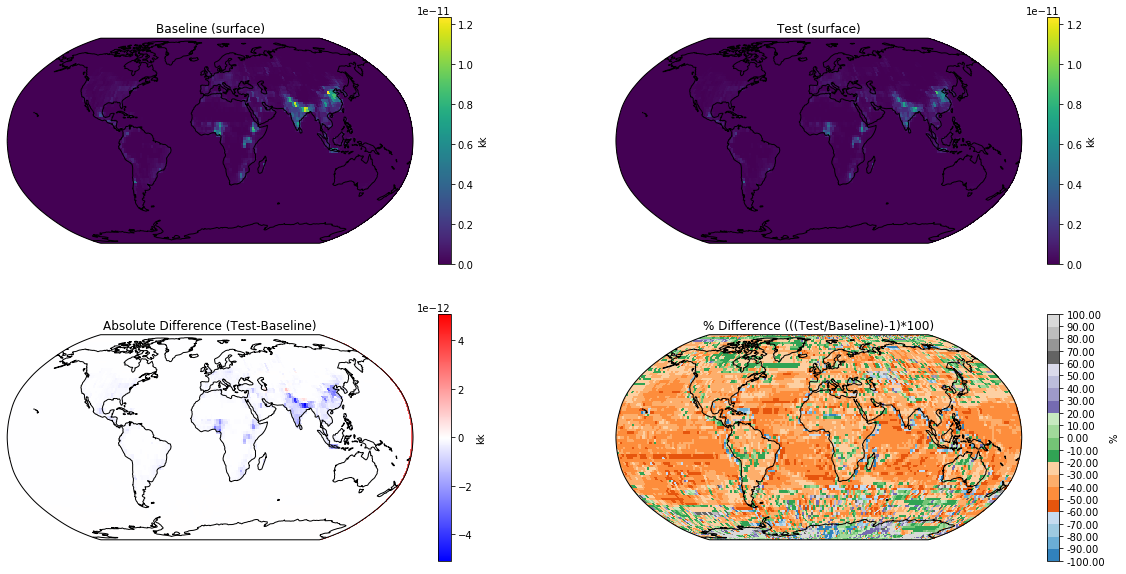

In [3]:
#maps with data concatenated previously using nrcat

bl       = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/bl/outfiles/2015060112/hyb/20150601_bl.nc')
test     = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/skp/outfiles/2015060112/hyb/20150601_skp.nc')


#var1 = 'TOCM_vgrid5'
#var2 = var1
#level = 78

#var_list =  bl.variables
#for var in list(var_list):
var='kk'    
    #if var.startswith(('_2DB1')):
        #print(var)
fig = plt.figure(figsize=(20,10))

data_1 = bl['TBCM_vgrid5'].mean(['time','level'])
data_2 = test['TBCM_vgrid5'].mean(['time','level'])

ax2 = plt.subplot(2,2,1,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(data_1.lon, data_1.lat, data_1, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
vmin, vmax = im2.get_clim() # top row plot limits #
im2.set_clim(vmin, vmax)
cb1 = fig.colorbar(im2, ax=ax2)
cb1.ax.set_ylabel(var)
ax2.set_title('Baseline (surface)')
#ax2.set_title(var1)

ax4 = plt.subplot(2,2,2,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(data_2.lon, data_2.lat, data_2, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
im4.set_clim(vmin, vmax)
cb2 = fig.colorbar(im4, ax=ax4)
cb2.ax.set_ylabel(var)
ax4.set_title('Test (surface)')
#ax4.set_title(var2)

pdiff = data_2-data_1
ax6 = plt.subplot(2,2,3,projection=ccrs.Robinson())
im6 = ax6.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=plt.cm.bwr, transform=ccrs.PlateCarree())
vmind, vmaxd = im6.get_clim()
im6.set_clim(vmind, -vmind)
cb3 = fig.colorbar(im6, ax=ax6)
cb3.ax.set_ylabel(var)
ax6.set_title('Absolute Difference (Test-Baseline)')

# make a color map of fixed colors
cmap = plt.cm.tab20c 
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds=np.arange(-100,110,10)
norm = colors.BoundaryNorm(bounds, cmap.N)

pdiff = ((data_2/data_1)-1)*100 
ax8 = plt.subplot(2,2,4,projection=ccrs.Robinson())
#im8 = ax8.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=plt.cm.bwr, transform=ccrs.PlateCarree())
im8 = ax8.pcolormesh(data_1.lon, data_1.lat, pdiff, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
im8.set_clim(-100, 100)
cbar_num_format = "%0.2f"
cb8 = fig.colorbar(im8, ax=ax8, cmap=cmap,norm=norm, boundaries=bounds, ticks=bounds,format=cbar_num_format)
#cb8 = fig.colorbar(im8, ax=ax8)
cb8.ax.set_ylabel('%')
ax8.set_title('% Difference (((Test/Baseline)-1)*100)')

for ax in [ax2,ax4,ax6,ax8]:
    ax.coastlines()

#save_path = '../public_html/PAM_optimization/PAM_step/GEM-MACH-PAM/debug/'+var+'_2015060102_sfc.png' 
#plt.savefig(save_path,bbox_inches='tight')  

In [ ]:
#!ls -l /space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/debug3_skp/outfiles/2015060112/hyb/


bl       = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/bl/outfiles/2015060112/hyb/20150601_bl.nc')
bl_skp   = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/skp/outfiles/2015060112/hyb/20150601_skp.nc')

TD1s = (bl_skp['_3DB1_vgrid5'].mean(['lat','lon','level']))
TD2s = (bl_skp['_3DB2_vgrid5'].mean(['lat','lon','level']))
TD3s = (bl_skp['_3DB3_vgrid5'].mean(['lat','lon','level']))
TD4s = (bl_skp['_3DB4_vgrid5'].mean(['lat','lon','level']))
TD5s = (bl_skp['_3DB5_vgrid5'].mean(['lat','lon','level']))
TD6s = (bl_skp['_3DB6_vgrid5'].mean(['lat','lon','level']))
TD7s = (bl_skp['_3DB7_vgrid5'].mean(['lat','lon','level']))
TD8s = (bl_skp['_3DB8_vgrid5'].mean(['lat','lon','level']))
TD9s = (bl_skp['_3DB9_vgrid5'].mean(['lat','lon','level']))


DD1s = (bl_skp['_2DB1'].mean(['lat','lon']))
DD2s = (bl_skp['_2DB2'].mean(['lat','lon']))
DD3s = (bl_skp['_2DB3'].mean(['lat','lon']))
DD4s = (bl_skp['_2DB4'].mean(['lat','lon']))
DD5s = (bl_skp['_2DB5'].mean(['lat','lon']))
DD6s = (bl_skp['_2DB6'].mean(['lat','lon']))
DD7s = (bl_skp['_2DB7'].mean(['lat','lon']))
DD8s = (bl_skp['_2DB8'].mean(['lat','lon']))
DD9s = (bl_skp['_2DB9'].mean(['lat','lon']))

#TD1 = (bl['_3DB1_vgrid5'].isel(level=slice(78,79)).mean(['lat','lon']))
TD1 = (bl['_3DB1_vgrid5'].mean(['lat','lon','level']))
TD2 = (bl['_3DB2_vgrid5'].mean(['lat','lon','level']))
TD3 = (bl['_3DB3_vgrid5'].mean(['lat','lon','level']))
TD4 = (bl['_3DB4_vgrid5'].mean(['lat','lon','level']))
TD5 = (bl['_3DB5_vgrid5'].mean(['lat','lon','level']))
TD6 = (bl['_3DB6_vgrid5'].mean(['lat','lon','level']))
TD7 = (bl['_3DB7_vgrid5'].mean(['lat','lon','level']))
TD8 = (bl['_3DB8_vgrid5'].mean(['lat','lon','level']))
TD9 = (bl['_3DB9_vgrid5'].mean(['lat','lon','level']))


DD1 = (bl['_2DB1'].mean(['lat','lon']))
DD2 = (bl['_2DB2'].mean(['lat','lon']))
DD3 = (bl['_2DB3'].mean(['lat','lon']))
DD4 = (bl['_2DB4'].mean(['lat','lon']))
DD5 = (bl['_2DB5'].mean(['lat','lon']))
DD6 = (bl['_2DB6'].mean(['lat','lon']))
DD7 = (bl['_2DB7'].mean(['lat','lon']))
DD8 = (bl['_2DB8'].mean(['lat','lon']))
DD9 = (bl['_2DB9'].mean(['lat','lon']))




In [ ]:
bl       = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/bl/outfiles/2015060112/hyb/20150601_bl.nc')
bl_skp   = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/skp2/outfiles/2015060112/hyb/20150601_argh2.nc')

TD7 = (bl['_3DB7_vgrid5'].mean(['lat','lon','level']))
TD6 = (bl['_3DB6_vgrid5'].mean(['lat','lon','level']))
dsetsb = [TD6,TD7]

TD7s = (bl_skp['_3DB2_vgrid5'].mean(['lat','lon','level']))
TD6s = (bl_skp['_3DB6_vgrid5'].mean(['lat','lon','level']))
dsetss = [TD6s,TD7s]

colours = ['k','b','c','g','m','orange','red','purple','grey',]
markers = ['o','s','d','D','+','.','*','>','^',]

fig = plt.figure(figsize=(20,7))   
ax2 = plt.subplot(1,2,1)
i=1
for dset, colour, marker in zip(dsetsb,colours, markers):
    ax2.plot(dset.time,dset,color=colour,marker=marker,alpha=0.5, label=str(i))
    i+=1
ax2.set_ylim(0,2e-13)
plt.legend()

ax2 = plt.subplot(1,2,2)
i=1
for dset, colour, marker in zip(dsetss,colours, markers):
    ax2.plot(dset.time,dset,color=colour,marker=marker,alpha=0.5, label=str(i))
    i+=1
ax2.set_ylim(0,2e-13)
plt.legend()

bl	debug2	debug3_skp     debug_tst_bl6  skp2
debug1	debug3	debug3_skpall  skp	      skp_old
<xarray.Dataset>
Dimensions:      (height: 1, lat: 90, level: 79, lon: 181, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2015-06-01T15:00:00
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 -79.0 -77.0 ...
  * lon          (lon) float32 5.00896e-06 2.0 4.0 6.0 8.0 10.0 12.0 14.0 ...
    leadtime     (time) timedelta64[ns] ...
    reftime      datetime64[ns] ...
  * height       (height) float32 1.5
  * level        (level) float32 0.000132994 0.00023263 0.000394663 ...
    a            (level) float64 ...
    b            (level) float64 ...
Data variables:
    DAS1         (time, lat, lon) float32 ...
    crs_latlon   |S1 ...
    DBM1         (time, lat, lon) float32 ...
    DDM1         (time, lat, lon) float32 ...
    DOM1         (time, lat, lon) float32 ...
    DSM1         (time, lat, lon) float32 ...
    EAS1         (time, lat, lon) float32 ...
    EBM1       

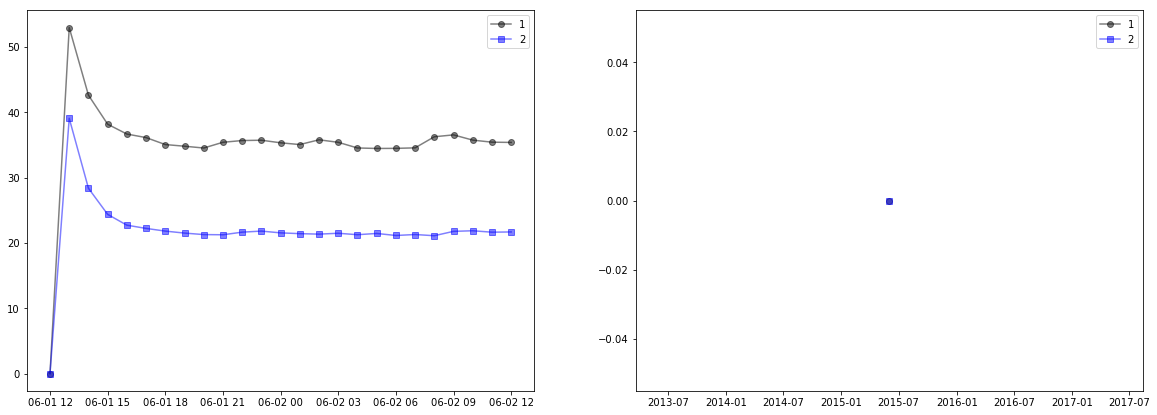

In [7]:
!ls /space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/

bl       = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/bl/outfiles/2015060112/hyb/20150601_bl.nc')
bl_skp   = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/skp/outfiles/2015060112/hyb/2015060112_003.nc')

print(bl_skp)

TD2 = (bl['_2DB2'].mean(['lat','lon']))
TD4 = (bl['_2DB6'].mean(['lat','lon']))
dsetsb = [TD4,TD2]

TST1 = (bl_skp['TST1'].mean(['lat','lon']))
TST2 = (bl_skp['TST2'].mean(['lat','lon']))
#db1  = (bl_skp['_2DB1'].isel(level=40).mean(['lat','lon']))

dsetss = [TST2,TST1]

colours = ['k','b','c','g','m','orange','red','purple','grey',]
markers = ['o','s','d','D','+','.','*','>','^',]

fig = plt.figure(figsize=(20,7))   
ax2 = plt.subplot(1,2,1)
i=1
for dset, colour, marker in zip(dsetsb,colours, markers):
    ax2.plot(dset.time,dset,color=colour,marker=marker,alpha=0.5, label=str(i))
    i+=1
#ax2.set_ylim(0,2e-13)
plt.legend()

ax2 = plt.subplot(1,2,2)
i=1
for dset, colour, marker in zip(dsetss,colours, markers):
    ax2.plot(dset.time,dset,color=colour,marker=marker,alpha=0.5, label=str(i))
    i+=1
#ax2.set_ylim(0,2e-13)
plt.legend()

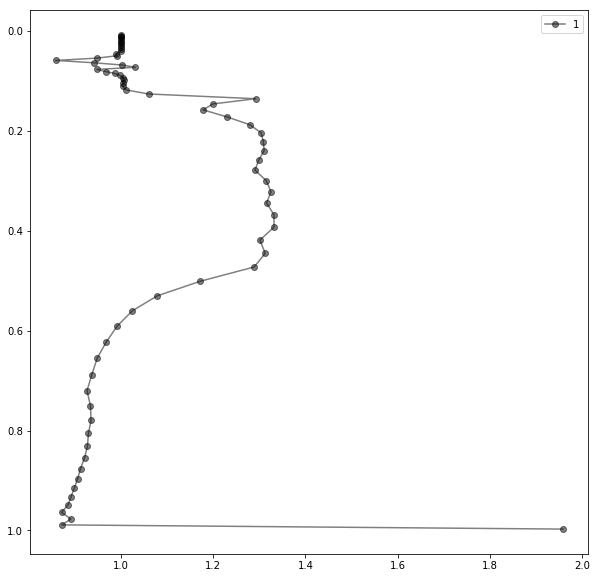

In [6]:
bl       = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/bl/outfiles/2015060112/hyb/20150601_bl.nc')
bl_skp   = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/GMP_test/skp2/outfiles/2015060112/hyb/20150601_skp2.nc')

colours = ['k','b','c','g','yellow','orange','red','purple','grey',]
markers = ['o','s','d','D','+','.','*','>','^',]

dsets = [bl['TBCM_vgrid5'].mean(['lat','lon','time'])/bl_skp['TBCM_vgrid5'].mean(['lat','lon','time'])]
fig = plt.figure(figsize=(10,10))   
ax2 = plt.subplot(1,1,1)
i=1
for dset, colour, marker in zip(dsets,colours, markers):
    ax2.plot(dset,dset.level,color=colour,marker=marker,alpha=0.5, label=str(i))
    i+=1
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
#list check

base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/profiling/'
year = 2015
run1 = 'baseline_2015'
run2 = 'tests_2015/new_erf_2015'

for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
    print(month)
    listcheck = checkFileList(year, month, base_dir+run1, base_dir+run2)
    print(listcheck)

In [ ]:
#save monthly means

base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/'
year = 2015
run = 'GMP_test/argh/outfiles'

months = [1,2,3,4,5,6,7,8,9,10,11,12]
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]

months = [6]
days_per_month = [7]


for month, end_day in zip(months,days_per_month):
    baseline_mean = getMonthlyMean(year, month, 1, end_day, base_dir,run,save=True)


In [ ]:
#plot monthly mean
base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/'
year = 2015
run1 = 'GMP_test/bl/outfiles'
run2 = 'GMP_test/argh/outfiles'

level = 0
month = 6
#end_days=[31,28,31,30,31,30,31,31,30,31,30,31]
end_days=[31,28,31,30,31,7,31,31,30,31,30,31]

month_file1 = os.path.join(base_dir,run1,('mean_'+str(year)+str(month).zfill(2)+'_01-'+str(end_days[month-1]).zfill(2)+'.nc'))
month_ds1 = xr.open_dataset(month_file1)

month_file2 = os.path.join(base_dir,run2,('mean_'+str(year)+str(month).zfill(2)+'_01-'+str(end_days[month-1]).zfill(2)+'.nc'))
month_ds2 = xr.open_dataset(month_file2)

var_list = xr.open_dataset(base_dir + run1 + "/2015060112/hyb/2015060112_000.nc").variables
for var1 in list(var_list):
    if 'vgrid5' not in var1:
        var2 = var1
        print(var1)
        if var1.startswith('T'):        
            level = 0
            mapPlot(var1,var2,level,month_ds1,month_ds2)
        else:
            continue
            #level = None
            #try:
            #    mapPlot(var1,var2,level,month_ds1,month_ds2)
            #except:
            #    print('skipping ' + var1)
            #    continue

In [ ]:
#plot monthly means for all variables and save
base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/testing/'
year = 2015
run1 = 'GMP_test/test1/outfiles'
run2 = 'GMP_test/test3/outfiles'

#months = [1,2,3,4,5,6,7,8,9,10,11,12]
#days_per_month=[31,28,31,30,31,30,31,31,30,31,30,31]

months = [6]
days_per_month=[30]


for month, end_day in zip(months,days_per_month):
    print('*****************',month,'*****************',end_day)
    month_file1 = os.path.join(base_dir,run1,('mean_'+str(year)+str(month).zfill(2)+'_01-'+str(end_day).zfill(2)+'.nc'))
    month_ds1 = xr.open_dataset(month_file1)

    month_file2 = os.path.join(base_dir,run2,('mean_'+str(year)+str(month).zfill(2)+'_01-'+str(end_day).zfill(2)+'.nc'))
    month_ds2 = xr.open_dataset(month_file2)

    var_list = xr.open_dataset(os.path.join(base_dir,run1,'2015060112/hyb/2015060112_000.nc')).variables
    for var1 in list(var_list):
        if 'vgrid5' not in var1:
            var2 = var1
            save_path = '../public_html/PAM_optimization/PAM_step/GEM-MACH-PAM/'+var1+'_2015'+str(month).zfill(2)+'.png'
            print(var1)
            if var1.startswith('T'):        
                level = 0
                mapPlot(var1,var2,level,month_ds1,month_ds2, savefig=True,closefig=True,save_path=save_path)
            else:
                level = None
                try:
                    mapPlot(var1,var2,level,month_ds1,month_ds2, savefig=True,closefig=True,save_path=save_path)
                except:
                    print('skipping ' + var1)
                    continue

In [ ]:
#get annual means
base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/profiling/'
year = 2015
run1 = 'erf/baseline_2015_restart_fixed_repeat'
run2 = 'erf/sun_2015_restart_fixed_repeat'

bl_annual_mean = getAnnualMean(year, base_dir, run1 )
tst_annual_mean = getAnnualMean(year, base_dir, run2 )

In [ ]:
#plot single annual mean
level = 0
var1=var2='TDM1_vgrid4'
mapPlot(var1,var2,level,bl_annual_mean,tst_annual_mean)

In [ ]:
#plot annual means for all variables
base_dir = '/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/GEM-MACH-PAM/profiling/'
year = 2015
run1 = 'erf/baseline_2015_restart_fixed_repeat'
run2 = 'erf/sun_2015_restart_fixed_repeat'

var_list = xr.open_dataset(os.path.join(base_dir,run1,'2015010112/hyb/2015010112_000.nc')).variables
for var1 in list(var_list):
    if 'vgrid5' not in var1:
        var2 = var1
        save_path = '../public_html/PAM_optimization/erf/GEM-MACH-PAM_2015/'+var1+'_20150101to20151130.png'
        print(var1)
        if var1.startswith('T'):        
            level = 0
            mapPlot(var1,var2,level,bl_annual_mean,tst_annual_mean, savefig=True,closefig=True,save_path=save_path)
        else:
            level = None
            try:
                mapPlot(var1,var2,level,bl_annual_mean,tst_annual_mean, savefig=True,closefig=True,save_path=save_path)
            except:
                print('skipping ' + var1)
                continue     

# Georgina's data

#find all .nc files from Feb
day_dictG = {}
for day in np.arange(1,29):
    day_dictG[day] = []
file_list = []
for root, dirs, files in os.walk("/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/Georgina_data/2015_02/"):
    for file in files:
        if file.startswith("201502") and file.endswith(".nc"):
            day_dictG[int(file[6:8])].append(os.path.join(root, file))
            
#make daily means
for day, file_list in day_dictG.items():
    data = xr.open_dataset('/space/hall3/sitestore/eccc/crd/ccrn/users/sah002/arch/Georgina_data/2015_02/201502'+str(day).zfill(2)+'12_001.nc')['TDN1_vgrid5']
    for file in file_list:
        if not file.endswith('001.nc'):
            data1 = xr.open_dataset(file)['TDN1_vgrid5']
            data = xr.concat((data1,data), dim='time')
    print('averaging Feb ' + str(day))
    day_dictG[day] = data.mean(dim='time')    

#make monthly mean
daily_meansG = []
for day, mean in day_dictG.items():
    daily_meansG.append(mean)

monthly_dataG = xr.concat(daily_meansG, dim='time')
monthly_meanG = monthly_dataG.mean(dim='time')   


In [ ]:
#histogram
data = baseline_mean[0]
print(10*np.std(data))
n, bins, patches = plt.hist(data)
#plt.ylim(0,10)
plt.show()

In [ ]:
#monthly mean vertically integrated
vmax=1e8
data1 = monthly_mean.mean(dim='level')
data2 = monthly_meanG.mean(dim='level')

fig = plt.figure(figsize=(24,18))

ax2 = plt.subplot(3,1,1,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(data1.lon, data1.lat,data1, cmap=plt.cm.viridis, transform=ccrs.PlateCarree(),vmax=vmax)
fig.colorbar(im2, ax=ax2)
ax2.set_title('New PAM - linear color scale')

ax4 = plt.subplot(3,1,2,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(data2.lon, data2.lat,data2, cmap=plt.cm.viridis, transform=ccrs.PlateCarree(),vmax=vmax)
fig.colorbar(im4, ax=ax4)
ax4.set_title('Old PAM - linear color scale')

ax6 = plt.subplot(3,1,3,projection=ccrs.Robinson())
im6 = ax6.pcolormesh(data1.lon, data1.lat,data1-data2, cmap=plt.cm.bwr, transform=ccrs.PlateCarree(),vmin=-vmax,vmax=vmax)
fig.colorbar(im6, ax=ax6)
ax6.set_title('Difference - linear color scale')

for ax in [ax2,ax4,ax6]:
    ax.coastlines()

In [ ]:
#vertical profile
#data1 = monthly_mean.mean(dim='lon')
data1 = monthly_mean.sel(lon=64)

fig = plt.figure(figsize=(14,12))

ax2 = plt.subplot(2,1,1)
vp2 = ax2.contourf(data1.lat,data1.level, data1, cmap=plt.cm.viridis)
ax2.invert_yaxis()  
ax2.set_xticks(np.arange(-80, 90, step=10))
axins = inset_axes(ax2,
                   width="1%",  # % of parent_bbox width
                   height="100%",  # % of parent_bbox height 
                   loc='lower left',
                   bbox_to_anchor=(-.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('level')
ax2.set_xlabel('latitude')

fig.colorbar(vp2, cax=axins)


ax4 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())
ax4.coastlines()
ax4.plot([64, 64], [90, -90],color='red', linestyle='--',transform=ccrs.PlateCarree())
ax4.plot([1, 359], [10, 10],color='grey', linestyle='-',linewidth=0.5,transform=ccrs.PlateCarree())
ax4.plot([1, 359], [20, 20],color='grey', linestyle='-',linewidth=0.5,transform=ccrs.PlateCarree())
ax4.plot([1, 359], [30, 30],color='grey', linestyle='-',linewidth=0.5,transform=ccrs.PlateCarree())
ax4.plot([1, 359], [40, 40],color='grey', linestyle='-',linewidth=0.5,transform=ccrs.PlateCarree())
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([64])
gl.ylocator = mticker.FixedLocator([10,20,30,40])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.savefig('../public_html/PAM_dust/201502_TDN1verticalprof_lon64.png',bbox_inches='tight')

In [ ]:
#daily mean at given level
for day in np.arange(0,29):
    vmax=7e8
    #day = 26
    level = 77
    data1 = monthly_data.sel(time=day)
    data2 = monthly_dataG.sel(time=day)

    fig = plt.figure(figsize=(24,18))

    ax2 = plt.subplot(3,1,1,projection=ccrs.Robinson())
    im2 = ax2.pcolormesh(data1.lon, data1.lat,data1[level], cmap=plt.cm.viridis, transform=ccrs.PlateCarree(),vmax=vmax)
    fig.colorbar(im2, ax=ax2)
    ax2.set_title('New PAM - linear color scale')

    ax4 = plt.subplot(3,1,2,projection=ccrs.Robinson())
    im4 = ax4.pcolormesh(data2.lon, data2.lat,data2[level], cmap=plt.cm.viridis, transform=ccrs.PlateCarree(),vmax=vmax)
    fig.colorbar(im4, ax=ax4)
    ax4.set_title('Old PAM - linear color scale')

    ax6 = plt.subplot(3,1,3,projection=ccrs.Robinson())
    im6 = ax6.pcolormesh(data1.lon, data1.lat,data1[level]-data2[level], cmap=plt.cm.bwr, transform=ccrs.PlateCarree(),vmin=-vmax,vmax=vmax)
    fig.colorbar(im6, ax=ax6)
    ax6.set_title('Difference - linear color scale')

    for ax in [ax2,ax4,ax6]:
        ax.coastlines()

    plt.savefig('../public_html/PAM_dust/201502' + str(day).zfill(2) +'_level' + str(level) + '.png',bbox_inches='tight')

In [ ]:
print(test)

In [ ]:
### VARS:

species_master(sp_IDMS) % dyn_name    =  'TDMS'
species_master(sp_IDMS) % dyn_lname   =  'TR/TDMS:P'
species_master(sp_IDMS) % dyn_string  =  'VN=TR/TDMS:P'//trim(tr_prop_s)//' ; ON=TDMS ; VD=DMS (PAM); VS=SLC;VB=D1'
species_master(sp_IDMS) % mol_wt      =   62.13
species_master(sp_ISO2) % dyn_name    =  'TPS2'
species_master(sp_ISO2) % dyn_lname   =  'TR/TPS2:P'
species_master(sp_ISO2) % dyn_string  =  'VN=TR/TPS2:P'//trim(tr_prop_s)//' ; ON=TPS2 ; VD=SO2 (PAM); VS=SLC;VB=D1'
species_master(sp_IHPO) % dyn_name    =  'TPHP'
species_master(sp_IHPO) % dyn_lname   =  'TR/TPHP:P'
species_master(sp_IHPO) % dyn_string  =  'VN=TR/TPHP:P'//trim(tr_prop_s)//' ; ON=TPHP ; VD=H2O2 (PAM); VS=SLC;VB=D1'
species_master(sp_IGS6) % dyn_name    =  'TPS4'
species_master(sp_IGS6) % dyn_lname   =  'TR/TPS4:P'
species_master(sp_IGS6) % dyn_string  =  'VN=TR/TPS4:P'//trim(tr_prop_s)//' ; ON=TPS4 ; VD=H2SO4 (PAM); VS=SLC;VB=D1'
species_master(sp_IGSP) % dyn_name    =  'TSOP'
species_master(sp_IGSP) % dyn_lname   =  'TR/TSOP:P'
species_master(sp_IGSP) % dyn_string  =  'VN=TR/TSOP:P'//trim(tr_prop_s)//' ; ON=TSOP ; VD=SOAP (PAM); VS=SLC;VB=D1'
species_master(sp_SSM1) % dyn_name    =  'TSM1'
species_master(sp_SSM1) % dyn_lname   =  'TR/TSM1:P'
species_master(sp_SSM1) % dyn_string  =  'VN=TR/TSM1:P'//trim(tr_prop_s)//' ; ON=TSM1 ; VD=PAM Sea Salt Bin 1 (mass) ; VS=SLC;VB=D1'
species_master(sp_SSM2) % dyn_name    =  'TSM2'
species_master(sp_SSM2) % dyn_lname   =  'TR/TSM2:P'
species_master(sp_SSM2) % dyn_string  =  'VN=TR/TSM2:P'//trim(tr_prop_s)//' ; ON=TSM2 ; VD=PAM Sea Salt Bin 2 (mass) ; VS=SLC;VB=D1'
species_master(sp_MDM1) % dyn_name    =  'TDM1'
species_master(sp_MDM1) % dyn_lname   =  'TR/TDM1:P'
species_master(sp_MDM1) % dyn_string  =  'VN=TR/TDM1:P'//trim(tr_prop_s)//' ; ON=TDM1 ; VD=PAM Mineral Dust Bin 1 (mass) ; VS=SLC;VB=D1'
species_master(sp_MDM2) % dyn_name    =  'TDM2'
species_master(sp_MDM2) % dyn_lname   =  'TR/TDM2:P'
species_master(sp_MDM2) % dyn_string  =  'VN=TR/TDM2:P'//trim(tr_prop_s)//' ; ON=TDM2 ; VD=PAM Mineral Dust Bin 2 (mass) ; VS=SLC;VB=D1'
species_master(sp_BCM)  % dyn_name    =  'TBCM'
species_master(sp_BCM)  % dyn_lname   =  'TR/TBCM:P'
species_master(sp_BCM)  % dyn_string  =  'VN=TR/TBCM:P'//trim(tr_prop_s)//' ; ON=TBCM ; VD=PAM Black Carbon (mass) ; VS=SLC;VB=D1'
species_master(sp_OCM)  % dyn_name    =  'TOCM'
species_master(sp_OCM)  % dyn_lname   =  'TR/TOCM:P'
species_master(sp_OCM)  % dyn_string  =  'VN=TR/TOCM:P'//trim(tr_prop_s)//' ; ON=TOCM ; VD=PAM Organic Carbon (mass) ; VS=SLC;VB=D1'
species_master(sp_OM1)  % dyn_name    =  'TOM1'
species_master(sp_OM1)  % dyn_lname   =  'TR/TOM1:P'
species_master(sp_OM1)  % dyn_string  =  'VN=TR/TOM1:P'//trim(tr_prop_s)//' ; ON=TOM1 ; VD=PAM Int. Mix Organic Carbon Bin 1 (mass) ; VS=SLC;VB=D1'
species_master(sp_OM2)  % dyn_name    =  'TOM2'
species_master(sp_OM2)  % dyn_lname   =  'TR/TOM2:P'
species_master(sp_OM2)  % dyn_string  =  'VN=TR/TOM2:P'//trim(tr_prop_s)//' ; ON=TOM2 ; VD=PAM Int. Mix Organic Carbon Bin 2 (mass) ; VS=SLC;VB=D1'
species_master(sp_OM3)  % dyn_name    =  'TOM3'
species_master(sp_OM3)  % dyn_lname   =  'TR/TOM3:P'
species_master(sp_OM3)  % dyn_string  =  'VN=TR/TOM3:P'//trim(tr_prop_s)//' ; ON=TOM3 ; VD=PAM Int. Mix Organic Carbon Bin 3 (mass) ; VS=SLC;VB=D1'
species_master(sp_BM1)  % dyn_name    =  'TBM1'
species_master(sp_BM1)  % dyn_lname   =  'TR/TBM1:P'
species_master(sp_BM1)  % dyn_string  =  'VN=TR/TBM1:P'//trim(tr_prop_s)//' ; ON=TBM1 ; VD=PAM Int. Mix Black Carbon Bin 1 (mass) ; VS=SLC;VB=D1'
species_master(sp_BM2)  % dyn_name    =  'TBM2'
species_master(sp_BM2)  % dyn_lname   =  'TR/TBM2:P'
species_master(sp_BM2)  % dyn_string  =  'VN=TR/TBM2:P'//trim(tr_prop_s)//' ; ON=TBM2 ; VD=PAM Int. Mix Black Carbon Bin 2 (mass) ; VS=SLC;VB=D1'
species_master(sp_BM3)  % dyn_name    =  'TBM3'
species_master(sp_BM3)  % dyn_lname   =  'TR/TBM3:P'
species_master(sp_BM3)  % dyn_string  =  'VN=TR/TBM3:P'//trim(tr_prop_s)//' ; ON=TBM3 ; VD=PAM Int. Mix Black Carbon Bin 3 (mass) ; VS=SLC;VB=D1'
species_master(sp_AS1)  % dyn_name    =  'TAS1'
species_master(sp_AS1)  % dyn_lname   =  'TR/TAS1:P'
species_master(sp_AS1)  % dyn_string  =  'VN=TR/TAS1:P'//trim(tr_prop_s)//' ; ON=TAS1 ; VD=PAM Int. Mix (NH4)2SO4 Bin 1 (mass) ; VS=SLC;VB=D1'
species_master(sp_AS2)  % dyn_name    =  'TAS2'
species_master(sp_AS2)  % dyn_lname   =  'TR/TAS2:P'
species_master(sp_AS2)  % dyn_string  =  'VN=TR/TAS2:P'//trim(tr_prop_s)//' ; ON=TAS2 ; VD=PAM Int. Mix (NH4)2SO4 Bin 2 (mass) ; VS=SLC;VB=D1'
species_master(sp_AS3)  % dyn_name    =  'TAS3'
species_master(sp_AS3)  % dyn_lname   =  'TR/TAS3:P'
species_master(sp_AS3)  % dyn_string  =  'VN=TR/TAS3:P'//trim(tr_prop_s)//' ; ON=TAS3 ; VD=PAM Int. Mix (NH4)2SO4 Bin 3 (mass) ; VS=SLC;VB=D1'
species_master(sp_SSN1) % dyn_name    =  'TSN1'
species_master(sp_SSN1) % dyn_lname   =  'TR/TSN1:P'
species_master(sp_SSN1) % dyn_string  =  'VN=TR/TSN1:P'//trim(tr_prop_s)//' ; ON=TSN1 ; VD=PAM Sea Salt Bin 1 (num) ; VS=SLC;VB=D1'
species_master(sp_SSN2) % dyn_name    =  'TSN2'
species_master(sp_SSN2) % dyn_lname   =  'TR/TSN2:P'
species_master(sp_SSN2) % dyn_string  =  'VN=TR/TSN2:P'//trim(tr_prop_s)//' ; ON=TSN2 ; VD=PAM Sea Salt Bin 2 (num) ; VS=SLC;VB=D1'
species_master(sp_MDN1) % dyn_name    =  'TDN1'
species_master(sp_MDN1) % dyn_lname   =  'TR/TDN1:P'
species_master(sp_MDN1) % dyn_string  =  'VN=TR/TDN1:P'//trim(tr_prop_s)//' ; ON=TDN1 ; VD=PAM Mineral Dust Bin 1 (num) ; VS=SLC;VB=D1'
species_master(sp_MDN2) % dyn_name    =  'TDN2'
species_master(sp_MDN2) % dyn_lname   =  'TR/TDN2:P'
species_master(sp_MDN2) % dyn_string  =  'VN=TR/TDN2:P'//trim(tr_prop_s)//' ; ON=TDN2 ; VD=PAM Mineral Dust Bin 2 (num) ; VS=SLC;VB=D1'
species_master(sp_BCN)  % dyn_name    =  'TBCN'
species_master(sp_BCN)  % dyn_lname   =  'TR/TBCN:P'
species_master(sp_BCN)  % dyn_string  =  'VN=TR/TBCN:P'//trim(tr_prop_s)//' ; ON=TBCN ; VD=PAM Black Carbon (num) ; VS=SLC;VB=D1'
species_master(sp_OCN)  % dyn_name    =  'TOCN'
species_master(sp_OCN)  % dyn_lname   =  'TR/TOCN:P'
species_master(sp_OCN)  % dyn_string  =  'VN=TR/TOCN:P'//trim(tr_prop_s)//' ; ON=TOCN ; VD=PAM Organic Carbon (num) ; VS=SLC;VB=D1'
species_master(sp_IMX1) % dyn_name    =  'TIN1'
species_master(sp_IMX1) % dyn_lname   =  'TR/TIN1:P'
species_master(sp_IMX1) % dyn_string  =  'VN=TR/TIN1:P'//trim(tr_prop_s)//' ; ON=TIN1 ; VD=PAM Int. Mix Bin 1 (num) ; VS=SLC;VB=D1'
species_master(sp_IMX2) % dyn_name    =  'TIN2'
species_master(sp_IMX2) % dyn_lname   =  'TR/TIN2:P'
species_master(sp_IMX2) % dyn_string  =  'VN=TR/TIN2:P'//trim(tr_prop_s)//' ; ON=TIN2 ; VD=PAM Int. Mix Bin 2 (num) ; VS=SLC;VB=D1'
species_master(sp_IMX3) % dyn_name    =  'TIN3'
species_master(sp_IMX3) % dyn_lname   =  'TR/TIN3:P'
species_master(sp_IMX3) % dyn_string  =  'VN=TR/TIN3:P'//trim(tr_prop_s)//' ; ON=TIN3 ; VD=PAM Int. Mix Bin 3 (num) ; VS=SLC;VB=D1'